# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

random.seed(42)
np.random.seed(42)

# Load and Process Data

In [2]:
# Load MovieLens dataset
data_path = 'ml-100k/u.data'
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(data_path, sep='\t', names=column_names)

In [3]:
# Preprocess the dataset
user_ids = data['user_id'].unique()
item_ids = data['item_id'].unique()
uid2idx = {uid: idx for idx, uid in enumerate(user_ids)}
iid2idx = {iid: idx for idx, iid in enumerate(item_ids)}
data['user_id'] = data['user_id'].map(uid2idx)
data['item_id'] = data['item_id'].map(iid2idx)

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Visualize Data

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,0,0,3,881250949
1,1,1,3,891717742
2,2,2,1,878887116
3,3,3,2,880606923
4,4,4,1,886397596


In [6]:
print('Number of users: ', len(user_ids))
print('Number of items: ', len(item_ids))
print('Number of interactions: ', len(data))
print('Average rating: ', data['rating'].mean())
print('Start Date: ', pd.to_datetime(data['timestamp'].min(), unit='s'))
print('End Date: ', pd.to_datetime(data['timestamp'].max(), unit='s'))

Number of users:  943
Number of items:  1682
Number of interactions:  100000
Average rating:  3.52986
Start Date:  1997-09-20 03:05:10
End Date:  1998-04-22 23:10:38


# Create Movie Lens Dataset

In [7]:
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return row['user_id'], row['item_id'], row['rating']

# Create NextItNet Model

In [8]:
class NextItNet(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, dilation_rates, dropout_rate=0.5):
        super(NextItNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.blocks = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        for rate in dilation_rates:
            self.blocks.append(
                nn.Sequential(
                    nn.Conv1d(emb_dim, emb_dim, kernel_size=3, padding=rate, dilation=rate),
                    nn.ReLU(),
                    nn.BatchNorm1d(emb_dim),
                    nn.Dropout(dropout_rate),
                )
            )
        self.fc = nn.Linear(emb_dim, 1)

    def forward(self, user_ids, item_ids):
        user_emb = self.user_emb(user_ids)
        item_emb = self.item_emb(item_ids)
        x = (user_emb * item_emb).unsqueeze(2)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = x.squeeze(2)
        x = self.fc(x)
        return x.squeeze(1)


# Initiate Model

In [9]:
# Hyperparameters
emb_dim = 32
dilation_rates = [1, 2, 4]
num_epochs = 50
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4

In [10]:
# Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NextItNet(len(user_ids), len(item_ids), emb_dim, dilation_rates).to(device)

In [11]:
# Prepare the data
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
# Set up the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
# Set up the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping settings
early_stopping_patience = 10
epochs_without_improvement = 0
best_test_loss = float('inf')

# Train Model

In [14]:
# Training loop
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs), desc='Epoch'):
    model.train()
    train_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids = user_ids.to(device, dtype=torch.long)
        item_ids = item_ids.to(device, dtype=torch.long)
        ratings = ratings.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(user_ids, item_ids)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

    # Evaluation loop
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for user_ids, item_ids, ratings in test_loader:
            user_ids = user_ids.to(device, dtype=torch.long)
            item_ids = item_ids.to(device, dtype=torch.long)
            ratings = ratings.to(device, dtype=torch.float)

            outputs = model(user_ids, item_ids)
            loss = criterion(outputs, ratings)

            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}')

    # Update the scheduler and check for early stopping
    scheduler.step(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement')
        break


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 5.96254571018219


Epoch:   2%|▏         | 1/50 [00:10<08:32, 10.46s/it]

Epoch 1/50, Test Loss: 1.3544334264317894
Epoch 2/50, Training Loss: 1.956990308189392


Epoch:   4%|▍         | 2/50 [00:17<06:52,  8.60s/it]

Epoch 2/50, Test Loss: 1.2957556885518846
Epoch 3/50, Training Loss: 1.6739486103057861


Epoch:   6%|▌         | 3/50 [00:25<06:19,  8.07s/it]

Epoch 3/50, Test Loss: 1.2765855174155751
Epoch 4/50, Training Loss: 1.5922717012405396


Epoch:   8%|▊         | 4/50 [00:32<05:59,  7.83s/it]

Epoch 4/50, Test Loss: 1.271760428787037
Epoch 5/50, Training Loss: 1.5320284608840942


Epoch:  10%|█         | 5/50 [00:40<05:48,  7.74s/it]

Epoch 5/50, Test Loss: 1.2700941741086875
Epoch 6/50, Training Loss: 1.5024163673400879


Epoch:  12%|█▏        | 6/50 [00:47<05:37,  7.67s/it]

Epoch 6/50, Test Loss: 1.2725953425571417
Epoch 7/50, Training Loss: 1.460926647758484


Epoch:  14%|█▍        | 7/50 [00:55<05:29,  7.65s/it]

Epoch 7/50, Test Loss: 1.2776690562059925
Epoch 8/50, Training Loss: 1.4318343627929688


Epoch:  16%|█▌        | 8/50 [01:03<05:21,  7.65s/it]

Epoch 8/50, Test Loss: 1.2595353768130018
Epoch 9/50, Training Loss: 1.3847131777763366


Epoch:  18%|█▊        | 9/50 [01:10<05:13,  7.65s/it]

Epoch 9/50, Test Loss: 1.2478805564011737
Epoch 10/50, Training Loss: 1.3369410028457642


Epoch:  20%|██        | 10/50 [01:18<05:05,  7.63s/it]

Epoch 10/50, Test Loss: 1.2162287360543658
Epoch 11/50, Training Loss: 1.2930950337409972


Epoch:  22%|██▏       | 11/50 [01:26<05:00,  7.69s/it]

Epoch 11/50, Test Loss: 1.2023849229144443
Epoch 12/50, Training Loss: 1.2436743064880371


Epoch:  24%|██▍       | 12/50 [01:33<04:52,  7.69s/it]

Epoch 12/50, Test Loss: 1.1826586935930192
Epoch 13/50, Training Loss: 1.1991719244003296


Epoch:  26%|██▌       | 13/50 [01:41<04:46,  7.73s/it]

Epoch 13/50, Test Loss: 1.148213464743013
Epoch 14/50, Training Loss: 1.1581504406929015


Epoch:  28%|██▊       | 14/50 [01:48<04:31,  7.55s/it]

Epoch 14/50, Test Loss: 1.1053162467707494
Epoch 15/50, Training Loss: 1.1256217127799988


Epoch:  30%|███       | 15/50 [01:56<04:22,  7.51s/it]

Epoch 15/50, Test Loss: 1.0706042313272026
Epoch 16/50, Training Loss: 1.0882319842338561


Epoch:  32%|███▏      | 16/50 [02:03<04:13,  7.45s/it]

Epoch 16/50, Test Loss: 1.0468960487918488
Epoch 17/50, Training Loss: 1.0644792387008668


Epoch:  34%|███▍      | 17/50 [02:11<04:07,  7.51s/it]

Epoch 17/50, Test Loss: 1.038558020713223
Epoch 18/50, Training Loss: 1.040460859489441


Epoch:  36%|███▌      | 18/50 [02:18<04:00,  7.53s/it]

Epoch 18/50, Test Loss: 1.0378446336005145
Epoch 19/50, Training Loss: 1.023153803062439


Epoch:  38%|███▊      | 19/50 [02:26<03:56,  7.64s/it]

Epoch 19/50, Test Loss: 1.0083439729775592
Epoch 20/50, Training Loss: 1.0040987210273742


Epoch:  40%|████      | 20/50 [02:34<03:48,  7.61s/it]

Epoch 20/50, Test Loss: 1.0045320110715878
Epoch 21/50, Training Loss: 0.9807570755958557


Epoch:  42%|████▏     | 21/50 [02:41<03:40,  7.60s/it]

Epoch 21/50, Test Loss: 0.9910624968777796
Epoch 22/50, Training Loss: 0.9652433482170105


Epoch:  44%|████▍     | 22/50 [02:49<03:33,  7.61s/it]

Epoch 22/50, Test Loss: 0.9902651450436586
Epoch 23/50, Training Loss: 0.944666307926178


Epoch:  46%|████▌     | 23/50 [02:57<03:25,  7.62s/it]

Epoch 23/50, Test Loss: 0.978852388585449
Epoch 24/50, Training Loss: 0.9253449324607849


Epoch:  48%|████▊     | 24/50 [03:04<03:15,  7.53s/it]

Epoch 24/50, Test Loss: 0.9888619112361009
Epoch 25/50, Training Loss: 0.9132364608764648


Epoch:  50%|█████     | 25/50 [03:11<03:07,  7.50s/it]

Epoch 25/50, Test Loss: 0.9758573387079178
Epoch 26/50, Training Loss: 0.9013309961318969


Epoch:  52%|█████▏    | 26/50 [03:19<02:58,  7.43s/it]

Epoch 26/50, Test Loss: 0.9716933540477874
Epoch 27/50, Training Loss: 0.8828020017623901


Epoch:  54%|█████▍    | 27/50 [03:26<02:51,  7.45s/it]

Epoch 27/50, Test Loss: 0.9788138133705042
Epoch 28/50, Training Loss: 0.871782723903656


Epoch:  56%|█████▌    | 28/50 [03:33<02:43,  7.45s/it]

Epoch 28/50, Test Loss: 0.9844192748616456
Epoch 29/50, Training Loss: 0.8627819060325622


Epoch:  58%|█████▊    | 29/50 [03:41<02:34,  7.36s/it]

Epoch 29/50, Test Loss: 0.9867231883820454
Epoch 30/50, Training Loss: 0.8502937023162842


Epoch:  60%|██████    | 30/50 [03:48<02:26,  7.34s/it]

Epoch 30/50, Test Loss: 0.9681743804816227
Epoch 31/50, Training Loss: 0.8473357815742493


Epoch:  62%|██████▏   | 31/50 [03:56<02:21,  7.42s/it]

Epoch 31/50, Test Loss: 0.9726765767024581
Epoch 32/50, Training Loss: 0.8376500226020813


Epoch:  64%|██████▍   | 32/50 [04:03<02:13,  7.39s/it]

Epoch 32/50, Test Loss: 0.9659915129849865
Epoch 33/50, Training Loss: 0.8286060526847839


Epoch:  66%|██████▌   | 33/50 [04:10<02:04,  7.35s/it]

Epoch 33/50, Test Loss: 0.969345282597147
Epoch 34/50, Training Loss: 0.8221348343849182


Epoch:  68%|██████▊   | 34/50 [04:18<01:58,  7.39s/it]

Epoch 34/50, Test Loss: 0.9567231152467667
Epoch 35/50, Training Loss: 0.8166686275482178


Epoch:  70%|███████   | 35/50 [04:25<01:52,  7.47s/it]

Epoch 35/50, Test Loss: 0.9528245014749515
Epoch 36/50, Training Loss: 0.8173114733695984


Epoch:  72%|███████▏  | 36/50 [04:33<01:45,  7.53s/it]

Epoch 36/50, Test Loss: 0.9649767879467861
Epoch 37/50, Training Loss: 0.8122672723770141


Epoch:  74%|███████▍  | 37/50 [04:40<01:36,  7.43s/it]

Epoch 37/50, Test Loss: 0.9509261694683391
Epoch 38/50, Training Loss: 0.804144101524353


Epoch:  76%|███████▌  | 38/50 [04:47<01:28,  7.34s/it]

Epoch 38/50, Test Loss: 0.9615292264397737
Epoch 39/50, Training Loss: 0.8008171996116639


Epoch:  78%|███████▊  | 39/50 [04:55<01:20,  7.32s/it]

Epoch 39/50, Test Loss: 0.9571188908473701
Epoch 40/50, Training Loss: 0.7929607656478882


Epoch:  80%|████████  | 40/50 [05:02<01:13,  7.32s/it]

Epoch 40/50, Test Loss: 0.9680559589604664
Epoch 41/50, Training Loss: 0.7894616479873657


Epoch:  82%|████████▏ | 41/50 [05:09<01:05,  7.30s/it]

Epoch 41/50, Test Loss: 0.9518353194947455
Epoch 42/50, Training Loss: 0.7911290693283081


Epoch:  84%|████████▍ | 42/50 [05:16<00:58,  7.25s/it]

Epoch 42/50, Test Loss: 0.936617850118382
Epoch 43/50, Training Loss: 0.7762517076015473


Epoch:  86%|████████▌ | 43/50 [05:23<00:50,  7.23s/it]

Epoch 43/50, Test Loss: 0.963142639512469
Epoch 44/50, Training Loss: 0.7801306698799133


Epoch:  88%|████████▊ | 44/50 [05:31<00:43,  7.23s/it]

Epoch 44/50, Test Loss: 0.9560915330413041
Epoch 45/50, Training Loss: 0.7733773225784302


Epoch:  90%|█████████ | 45/50 [05:38<00:35,  7.17s/it]

Epoch 45/50, Test Loss: 0.9569655121511714
Epoch 46/50, Training Loss: 0.774902614402771


Epoch:  92%|█████████▏| 46/50 [05:45<00:28,  7.17s/it]

Epoch 46/50, Test Loss: 0.9580431891854402
Epoch 47/50, Training Loss: 0.7743651621818542


Epoch:  94%|█████████▍| 47/50 [05:52<00:21,  7.19s/it]

Epoch 47/50, Test Loss: 0.9471551195071761
Epoch 48/50, Training Loss: 0.7775798803329468


Epoch:  96%|█████████▌| 48/50 [05:59<00:14,  7.18s/it]

Epoch 48/50, Test Loss: 0.9489935002509197
Epoch 00048: reducing learning rate of group 0 to 1.0000e-04.
Epoch 49/50, Training Loss: 0.7497771289825439


Epoch:  98%|█████████▊| 49/50 [06:06<00:07,  7.15s/it]

Epoch 49/50, Test Loss: 0.9498444199562073
Epoch 50/50, Training Loss: 0.7524298106193542


Epoch: 100%|██████████| 50/50 [06:14<00:00,  7.48s/it]

Epoch 50/50, Test Loss: 0.941826886432186


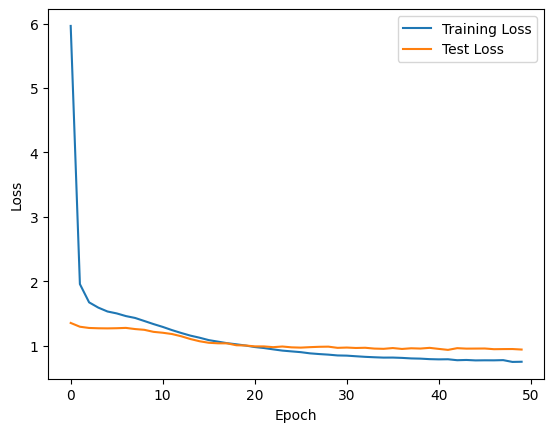

In [15]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Outcome Visualization

In [16]:
print('Train Dataset Length: ', len(train_dataset))
print('Test Dataset Length: ', len(test_dataset))

Train Dataset Length:  80000
Test Dataset Length:  20000


In [17]:
for _ in range(5):
    user_id, item_id, rating = random.choice(test_dataset)
    user_id = torch.tensor([user_id]).to(device)
    item_id = torch.tensor([item_id]).to(device)
    rating = torch.tensor([rating]).to(device)
    output = model(user_id, item_id)
    print(f'User: {user_id.item()}, Item: {item_id.item()}, Actual Rating: {rating.item()}, Predicted Rating: {output.item()}')

User: 505, Item: 403, Actual Rating: 2, Predicted Rating: 2.226226806640625
User: 188, Item: 360, Actual Rating: 4, Predicted Rating: 3.710909843444824
User: 229, Item: 487, Actual Rating: 3, Predicted Rating: 3.798381805419922
User: 102, Item: 114, Actual Rating: 3, Predicted Rating: 3.0368387699127197
User: 153, Item: 311, Actual Rating: 3, Predicted Rating: 3.980167865753174


# Recommender Test

In [18]:
movies = pd.read_csv('ml-100k/movies.csv', index_col='movieId')
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [19]:
movies.loc[[1]]['title'].values[0]

'Toy Story (1995)'

### New User Test

In [20]:
# Create X random interactions
num_interaction = 10
new_user_id = len(user_ids)
random_item_ids = np.random.choice(item_ids.cpu(), num_interaction)
random_ratings = np.random.randint(1, 6, num_interaction)

# Predict for new user
model.eval()
all_item_ids = torch.arange(len(item_ids)).to(device)
user_ids = torch.full((len(item_ids),), new_user_id).to(device, dtype=torch.long)
with torch.no_grad():
    outputs = model(user_ids, all_item_ids).cpu().numpy()

# Get the top 10 recommendations
top_10 = np.argsort(outputs)[::-1][:10]
print('Top 10 Recommendations:')
for item_id in top_10:
    movie = movies.loc[[item_id]]['title'].values[0]
    print(f'Movie: {movie}, Item ID: {item_id}, Predicted Rating: {outputs[item_id]}')


Top 10 Recommendations:
Movie: Dangerous Minds (1995), Item ID: 31, Predicted Rating: 3.8146860599517822
Movie: Heat (1995), Item ID: 6, Predicted Rating: 3.802922248840332
Movie: Toy Story (1995), Item ID: 1, Predicted Rating: 3.7207744121551514
Movie: Dracula: Dead and Loving It (1995), Item ID: 12, Predicted Rating: 3.720365524291992
Movie: Othello (1995), Item ID: 26, Predicted Rating: 3.714259624481201
Movie: GoldenEye (1995), Item ID: 10, Predicted Rating: 3.671403408050537
Movie: Get Shorty (1995), Item ID: 21, Predicted Rating: 3.5600483417510986
Movie: Assassins (1995), Item ID: 23, Predicted Rating: 3.5440378189086914
Movie: Powder (1995), Item ID: 24, Predicted Rating: 3.5376064777374268
Movie: Sense and Sensibility (1995), Item ID: 17, Predicted Rating: 3.5355310440063477


### New Movie Test

In [21]:
# Create X random interactions
num_interaction = 10
new_item_id = len(item_ids)
random_user_ids = np.random.choice(user_ids.cpu(), num_interaction)
random_ratings = np.random.randint(1, 6, num_interaction)

# Predict for new item
model.eval()
all_user_ids = torch.arange(len(user_ids)).to(device)
item_ids = torch.full((len(user_ids),), new_item_id).to(device, dtype=torch.long)
with torch.no_grad():
    outputs = model(all_user_ids, item_ids).cpu().numpy()

# Get the top 10 recommendations
top_10 = np.argsort(outputs)[::-1][:10]
print('Top 10 Users to recommend to:')
for user_id in top_10:
    print(f'User ID: {user_id}, Predicted Rating: {outputs[user_id]}')

Top 10 Users to recommend to:
User ID: 18, Predicted Rating: 4.03505277633667
User ID: 2, Predicted Rating: 4.024545669555664
User ID: 1, Predicted Rating: 4.02407169342041
User ID: 5, Predicted Rating: 4.002097129821777
User ID: 12, Predicted Rating: 3.999988079071045
User ID: 3, Predicted Rating: 3.998711585998535
User ID: 31, Predicted Rating: 3.989100933074951
User ID: 9, Predicted Rating: 3.9579617977142334
User ID: 15, Predicted Rating: 3.942776918411255
User ID: 20, Predicted Rating: 3.942246675491333
